# Estimating the historical novelty of trimer discovery

In [130]:
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import rdkit
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdChemReactions
from rdkit import DataStructs
import sqlite3
import pandas as pd
from tqdm import tqdm
import seaborn as sns

sns.set(context="notebook", style="ticks", font="Arial", font_scale=1.8, rc={"svg.fonttype": "none", "lines.linewidth": 1.5, "figure.autolayout": True,
                                                                           "mathtext.fontset": "custom", "mathtext.it": "Arial:italic", "mathtext.rm": "Arial", "mathtext.bf": "Arial:bold"})

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from IPython.display import Image, display

In [2]:
class Rxn(object):
    
    def __init__(self, rdict, rxn_id):
        self.products_smiles = rdict['products']
        self.reactants_smiles = rdict['reactants']
        self.id = rxn_id
        self.products_mols = [rdkit.Chem.MolFromSmiles(s) 
                              for s in self.products_smiles]
        
        self.reactants_mols = [rdkit.Chem.MolFromSmiles(s) 
                              for s in self.reactants_smiles]
        self.rxn_smiles = '.'.join(self.reactants_smiles) + '>>' + '.'.join(self.products_smiles)
        self.rxn = rdChemReactions.ReactionFromSmarts(self.rxn_smiles)
        self.__fp = rdChemReactions.CreateDifferenceFingerprintForReaction(self.rxn)
        
    #def get_fp(self, mol):
        
       # fp = AllChem.GetMorganFingerprintAsBitVect()
    @property
    def invalid(self):
        if None in self.products_mols:
            return True
        if None in self.reactants_mols:
            return True
        if len(self.products_smiles) == 0:
            return True
        return False
        
    
    @property
    def fp(self):
        return self.__fp
    
    def has_match(self, subst):
        if None in self.products_mols:
            return False
        matches = [p.HasSubstructMatch(subst) for p in self.products_mols]
        return any(matches)
        
    def __repr__(self):
        return self.rxn_smiles

## Query reaxys database for specific reactants

In [12]:
smiles_connection = sqlite3.Connection("/mnt/hdd/smilesDB.db")

In [13]:
db_connection = sqlite3.Connection("/mnt/hdd/fullDB.db")

In [98]:
def find_smiles(xrn):
    result = smiles_connection.execute("SELECT smiles FROM smiles WHERE RXN=?", [xrn]).fetchone()
    if result:
        return result[0]
    else:
        print(f"No smiles found for XRN={xrn}")

def find_rxn(smiles):
    result = smiles_connection.execute("SELECT RXN FROM smiles WHERE smiles=?", [smiles]).fetchone()
    if result:
        return result[0]
    else:
        print(f"No XRN found for SMILES={smiles}")

In [69]:
find_smiles(2331606)

'[C]=NCS(=O)(=O)c1ccc(cc1)C'

In [32]:
tosmic_isocyanate_xrn = find_rxn("O=C=NCS(=O)(=O)c1ccc(cc1)C")

In [29]:
tosmic_xrn = find_rxn("[C]=NCS(=O)(=O)c1ccc(cc1)C")

In [42]:
def contains(xrn):
    def inner(pkl):
        try:
            xrns = pickle.loads(pkl)
        except Exception as e:
            print(e)
            return 0
        return xrn in xrns
    return inner

In [43]:
contains_tosmic = contains(tosmic_xrn)
contains_tosmic_isocyanate = contains(tosmic_isocyanate_xrn)

db_connection.create_function("contains_tosmic", 1, contains_tosmic)
db_connection.create_function("contains_tosmic_isocyanate", 1, contains_tosmic_isocyanate)

In [59]:
with tqdm() as t:
    db_connection.set_progress_handler(lambda: t.update(100000) and 0, 100000)
    result = pd.read_sql("SELECT ID, RXRN, PXRN FROM reactions WHERE contains_tosmic(RXRN) > 0", db_connection)
    db_connection.set_progress_handler(None, 1)

result['RXRN'] = result['RXRN'].apply(pickle.loads)

result['PXRN'] = result['PXRN'].apply(pickle.loads)

result

In [65]:
with tqdm() as t:
    db_connection.set_progress_handler(lambda: t.update() and 0, 100000)
    result_isocyanate = pd.read_sql("SELECT ID, RXRN, PXRN FROM reactions WHERE contains_tosmic_isocyanate(RXRN) > 0", db_connection)
    db_connection.set_progress_handler(None, 1)

result_isocyanate['RXRN'] = result_isocyanate['RXRN'].apply(pickle.loads)

result_isocyanate['PXRN'] = result_isocyanate['PXRN'].apply(pickle.loads)

result_isocyanate

In [104]:
result

,ID,RXRN,PXRN
0,882335,"[105341, 2331606]",[971775]
1,882398,"[105342, 2331606]",[971865]
2,882454,"[105343, 2331606]",[971864]
3,884120,"[105819, 2331606]",[971989]
4,894403,"[107811, 2331606]",[973719]
...,...,...,...
4325,42974863,"[2331606, 385735]",[29719411]
4326,28416925,"[2331606, 906816]",[19121506]
4327,37853681,"[2331606, 3537963]",[1220369]
4328,30328421,"[21207062, 2331606, 471175]",[21207102]


In [99]:
def generate_dict(table):
    result = {}
    for row in tqdm(table.itertuples()):
        reactants = [find_smiles(r) for r in row.RXRN]
        products = [find_smiles(p) for p in row.PXRN]
        if (None not in reactants) and (None not in products):
            result[row.ID] = {
                "reactants": reactants,
                "products": products
        }
    return result

In [74]:
%pdb on

Automatic pdb calling has been turned ON


In [105]:
data = generate_dict(result)
data_isocyanate = generate_dict(result_isocyanate)

1478it [00:00, 7488.02it/s]

No smiles found for XRN=5427883
No smiles found for XRN=6138040
No smiles found for XRN=3586346
No smiles found for XRN=3534957
No smiles found for XRN=5508994
No smiles found for XRN=7579771
No smiles found for XRN=7579783
No smiles found for XRN=9255148
No smiles found for XRN=8385606
No smiles found for XRN=9752939
No smiles found for XRN=8387026
No smiles found for XRN=9753619
No smiles found for XRN=9696499
No smiles found for XRN=9695647
No smiles found for XRN=9696561
No smiles found for XRN=9696889
No smiles found for XRN=9757623
No smiles found for XRN=9757635
No smiles found for XRN=9996606
No smiles found for XRN=15625156
No smiles found for XRN=9543141
No smiles found for XRN=5719149
No smiles found for XRN=5719479
No smiles found for XRN=14198190
No smiles found for XRN=14198902
No smiles found for XRN=10335579
No smiles found for XRN=14198729
No smiles found for XRN=15687245
No smiles found for XRN=14198540
No smiles found for XRN=14199156
No smiles found for XRN=14198359

2774it [00:00, 6867.90it/s]

No smiles found for XRN=19752964
No smiles found for XRN=19752967
No smiles found for XRN=20446701
No smiles found for XRN=20446725
No smiles found for XRN=20446703
No smiles found for XRN=20446726
No smiles found for XRN=20446704
No smiles found for XRN=20446727
No smiles found for XRN=20446702
No smiles found for XRN=20446728
No smiles found for XRN=23123442
No smiles found for XRN=18366996
No smiles found for XRN=24052324
No smiles found for XRN=26945258
No smiles found for XRN=29625934
No smiles found for XRN=20817490
No smiles found for XRN=30055500
No smiles found for XRN=30055496
No smiles found for XRN=30055502
No smiles found for XRN=14199425
No smiles found for XRN=11759845
No smiles found for XRN=11323233
No smiles found for XRN=14208881
No smiles found for XRN=26945279
No smiles found for XRN=26945252
No smiles found for XRN=30297183
No smiles found for XRN=13994305
No smiles found for XRN=13992845
No smiles found for XRN=11405122
No smiles found for XRN=14563211
No smiles 

3821it [00:00, 5904.25it/s]

No smiles found for XRN=26621875
No smiles found for XRN=26621887
No smiles found for XRN=26621900
No smiles found for XRN=26621902
No smiles found for XRN=20208670
No smiles found for XRN=23587939
No smiles found for XRN=26621889
No smiles found for XRN=26885595
No smiles found for XRN=21273160
No smiles found for XRN=21273162
No smiles found for XRN=23786550
No smiles found for XRN=23786544
No smiles found for XRN=31271326
No smiles found for XRN=31271342
No smiles found for XRN=15747817
No smiles found for XRN=27641281
No smiles found for XRN=21155636
No smiles found for XRN=27641291
No smiles found for XRN=27641307
No smiles found for XRN=27641324
No smiles found for XRN=27641308
No smiles found for XRN=27641325
No smiles found for XRN=27641313
No smiles found for XRN=27641330
No smiles found for XRN=23159675
No smiles found for XRN=29847298
No smiles found for XRN=29847302
No smiles found for XRN=29847303
No smiles found for XRN=29847306
No smiles found for XRN=13905534
No smiles 

4330it [00:00, 6250.01it/s]
82it [00:00, 7090.08it/s]

No smiles found for XRN=29697181
No smiles found for XRN=27641317
No smiles found for XRN=27641334
No smiles found for XRN=4933628
No smiles found for XRN=17965131
No smiles found for XRN=27037351
No smiles found for XRN=27037338
No smiles found for XRN=28703205
No smiles found for XRN=19422578
No smiles found for XRN=19307075
No smiles found for XRN=22807113
No smiles found for XRN=22807130
No smiles found for XRN=27641319
No smiles found for XRN=27641336
No smiles found for XRN=30040925
No smiles found for XRN=23252661
No smiles found for XRN=26585918
No smiles found for XRN=26585892
No smiles found for XRN=22807104
No smiles found for XRN=22807123
No smiles found for XRN=23252655
No smiles found for XRN=26585885
No smiles found for XRN=26585886
No smiles found for XRN=30040922
No smiles found for XRN=30040921
No smiles found for XRN=18920742
No smiles found for XRN=21207062
No smiles found for XRN=21207083
No smiles found for XRN=21207062
No smiles found for XRN=21207085
No smiles f

In [101]:
with open('tosmic_reaction_smiles.pickle', 'rb') as r_file:
    data_old = pickle.load(r_file)

In [137]:
rxns_tosmic = [Rxn(data[k], k) for k in data.keys()]
print('Total number of rxns {}'.format(len(rxns)))

rxns_tosmic = [r for r in rxns if not r.invalid]
print('Total number of valid rxns {}'.format(len(rxns)))

RDKit ERROR: [18:41:26] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:26] Explicit valence for atom # 1 

Total number of rxns 1652
Total number of valid rxns 1652


RDKit ERROR: [18:41:26] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:27] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:27] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:27] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:27] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [18:41:27] Explicit valence for atom # 1 N, 5, is greater than permitted


In [110]:
rxns_isocyanate = [Rxn(v, k) for k, v in data_isocyanate.items()]
print('Total number of isocyanate rxns {}'.format(len(rxns_isocyanate)))

rxns_isocyanate = [r for r in rxns_isocyanate if not r.invalid]
print('Total number of valid isocyanate rxns {}'.format(len(rxns_isocyanate)))

Total number of isocyanate rxns 40
Total number of valid isocyanate rxns 40


In [158]:
rxns = rxns_isocyanate.copy()

In [145]:
trimer_dict = {'reactants':['[C]=NCS(=O)(=O)c1ccc(cc1)C'],
              'products':['O=C(NCS(C1=CC=C(C)C=C1)(=O)=O)CN(CC(NCS(=O)(C2=CC=C(C)C=C2)=O)=O)CC(NCS(=O)(C3=CC=C(C)C=C3)=O)=O']}


trimer_rxn = Rxn(trimer_dict, 0)

## Comparison of fingerprint between tosmic reactions

In [159]:
rxns.append(trimer_rxn)
cross_similarities_dicts = []
cross_similarities = []
for rxn_a in tqdm(rxns):
    
    rxn_similarities = {rid: DataStructs.TanimotoSimilarity(rxn_a.fp, rxn_b.fp)
                    for rid, rxn_b in enumerate(rxns)}
    cross_similarities_dicts.append(rxn_similarities)
    cross_similarities.append([DataStructs.TanimotoSimilarity(rxn_a.fp, rxn_b.fp)
                    for rxn_b in rxns])

cross_similarities = np.array(cross_similarities)

#rxn_similarities = {rid: DataStructs.TanimotoSimilarity(trimer_rxn_fp, rxn.get_rxn_fp())
                   # for rid, rxn in enumerate(rxns)}


100%|██████████| 41/41 [00:00<00:00, 1773.80it/s]


Similarity cross correlation based of fp change; the  last column/row is the trimer reaction

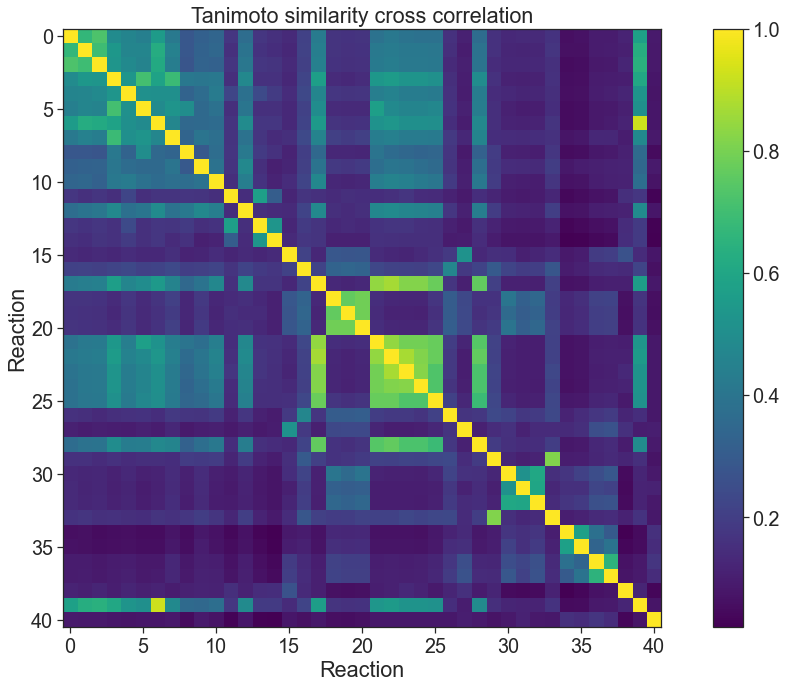

In [160]:
plt.figure(figsize=(15,10))
plt.title('Tanimoto similarity cross correlation')
plt.xlabel('Reaction')
plt.ylabel('Reaction')
plt.imshow(cross_similarities, cmap='viridis')
plt.colorbar()
plt.savefig("tanimoto.png", transparent=True, dpi=150)

This histogram shows average similarity of all reactions, the red line is the trimer reaction|

Trimer reaction average similarity 0.10519523577683779


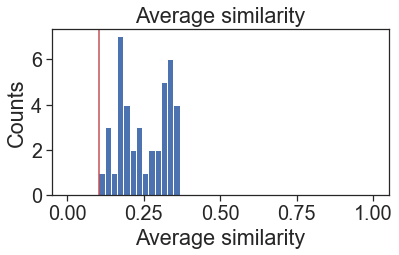

In [161]:
average_similarities = np.mean(cross_similarities, axis=1)
plt.hist(average_similarities, bins=np.linspace(0, 1, 50))
plt.axvline(average_similarities[-1], c='r') 
plt.title('Average similarity')
plt.ylabel('Counts')
plt.xlabel('Average similarity')
plt.savefig('average-similarity.svg', transparent=True)
print('Trimer reaction average similarity', average_similarities[-1])

## Loking only for trimer reaction

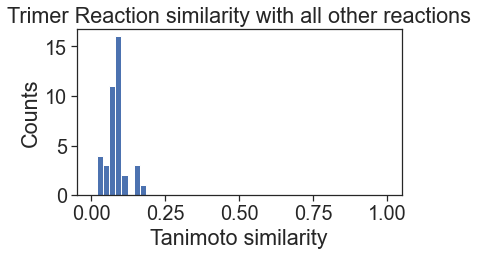

In [162]:
plt.hist(cross_similarities[-1][:-1], bins=np.linspace(0, 1, 50))
plt.title('Trimer Reaction similarity with all other reactions')
plt.xlabel('Tanimoto similarity')
plt.ylabel('Counts')
plt.savefig('trimer-similarity.svg', transparent=True)

## Ten most similar reactions

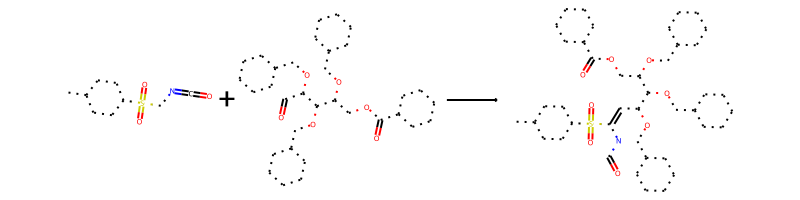

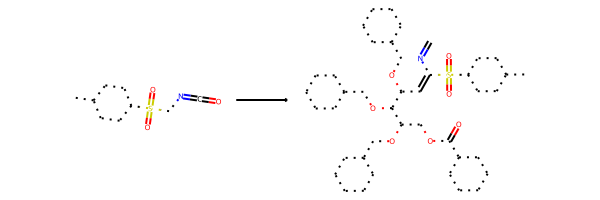

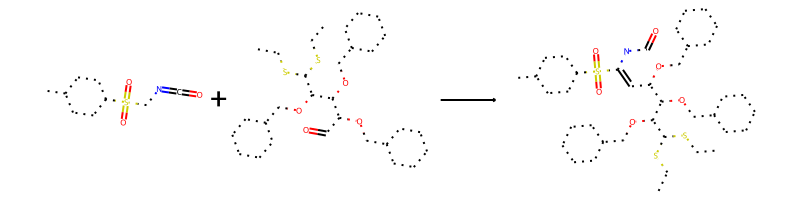

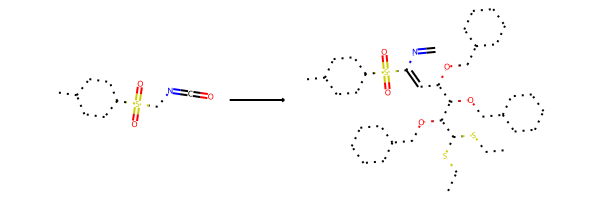

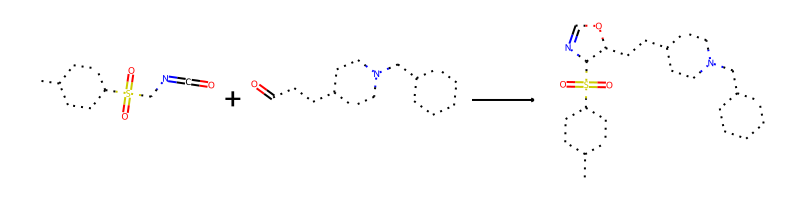

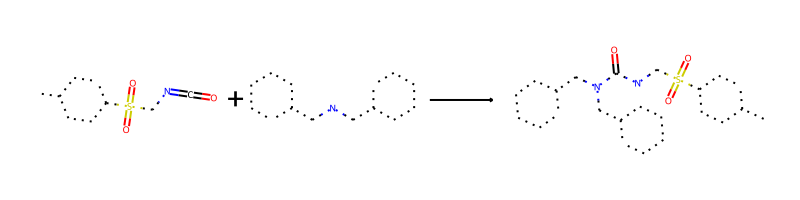

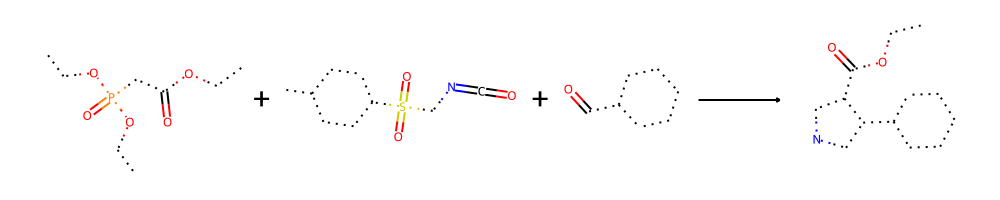

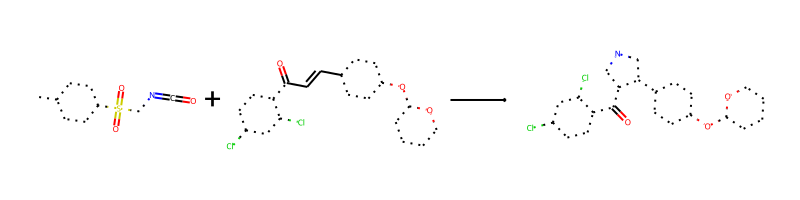

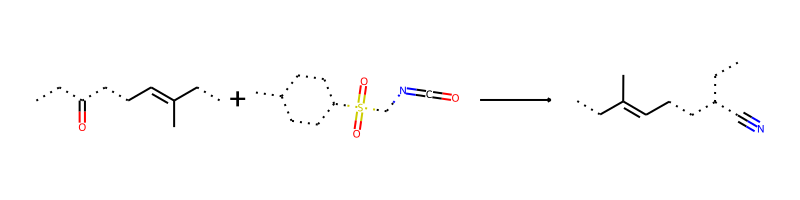

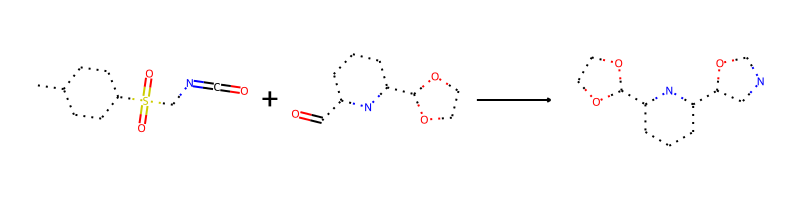

In [164]:
sorted_similarities = sorted(cross_similarities_dicts[-1], key=rxn_similarities.get, reverse=True)
for rxn_id in sorted_similarities[1:11]:
    rxn = rdChemReactions.ReactionFromSmarts(rxns[rxn_id].rxn_smiles)
    img = Draw.ReactionToImage(rxn)
    display(img)

##  t-SNE emeddings of FP changes and kernel density estimation; green dot trimer reaction

In [165]:
fps = np.array([list(r.fp) for r in rxns]) 
x_tsne = TSNE(n_components=2, verbose=2).fit_transform(fps)

[t-SNE] Computing 40 nearest neighbors...
[t-SNE] Indexed 41 samples in 0.000s...
[t-SNE] Computed neighbors for 41 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 41 / 41
[t-SNE] Mean sigma: 228.004266
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 47.3614349, gradient norm = 0.5670457 (50 iterations in 0.207s)
[t-SNE] Iteration 100: error = 47.6865463, gradient norm = 0.4931785 (50 iterations in 0.016s)
[t-SNE] Iteration 150: error = 45.1184464, gradient norm = 0.4816481 (50 iterations in 0.017s)
[t-SNE] Iteration 200: error = 44.6409302, gradient norm = 0.4141330 (50 iterations in 0.016s)
[t-SNE] Iteration 250: error = 52.7777557, gradient norm = 0.4002770 (50 iterations in 0.017s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.777756
[t-SNE] Iteration 300: error = 0.9789745, gradient norm = 0.0012847 (50 iterations in 0.016s)
[t-SNE] Iteration 350: error = 0.7723606, gradient norm = 0.0006433 (50

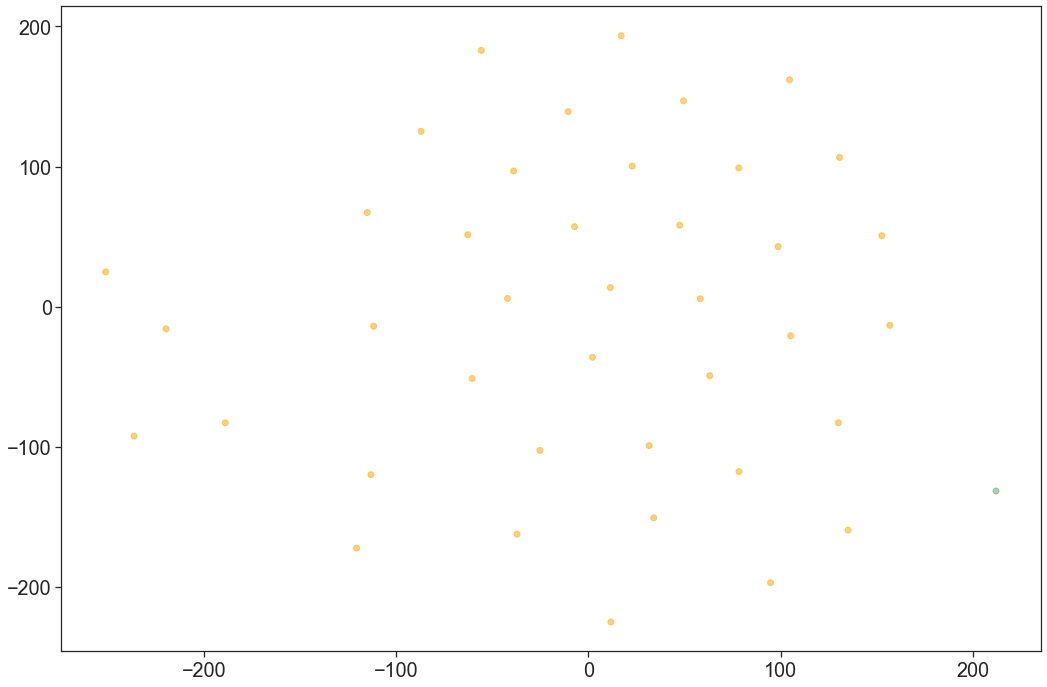

/home/group/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/group/.local/lib/python3.9/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 4.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/group/.local/lib/python3.9/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


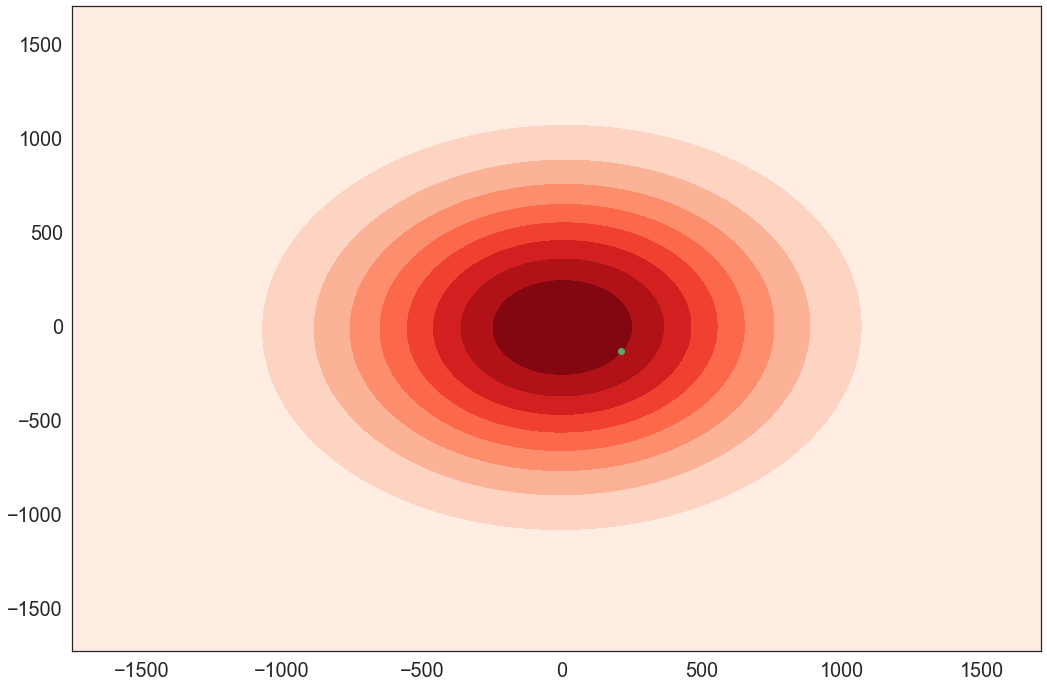

In [166]:
plt.figure(figsize=(15,10))
colors =  (len(x_tsne)-1)*['orange'] + ['g'] 
plt.scatter(x_tsne[:, 0], x_tsne[:,1], c=colors, alpha=0.5)
plt.show()
plt.figure(figsize=(15,10))
sns.set_style("white")
sns.kdeplot(x_tsne[:,0], x_tsne[:,1], cmap="Reds", shade=True, shade_lowest=True, bw=4.5)
plt.scatter(x_tsne[-1:,0], x_tsne[-1:,1], c=colors[-1:], alpha=1.0)

## Looking for substructures

In [168]:
def look_for_subtructures(rxns, smarts):
    substructure = rdkit.Chem.MolFromSmarts(smarts)
    display(substructure)
    matches = [r.has_match(substructure) for r in rxns]
    matches = np.where(matches)[0]
    for i in list(matches):
        rxn = rdChemReactions.ReactionFromSmarts(rxns[i].rxn_smiles)
        img = Draw.ReactionToImage(rxn)
        display(img)

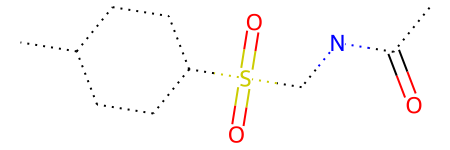

In [169]:
look_for_subtructures(rxns, '[CH1]C(=O)N[CH2]S(=O)(=O)c1ccc(C)cc1')

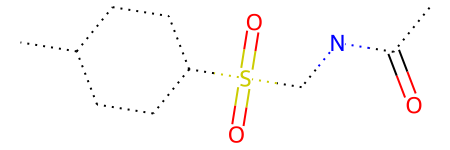

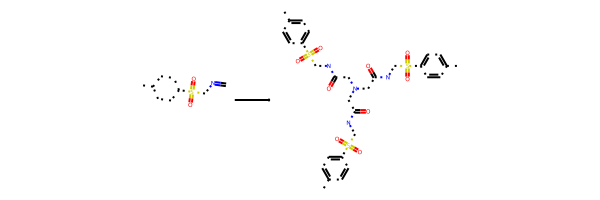

In [170]:
look_for_subtructures(rxns, '[CH2]C(=O)N[CH2]S(=O)(=O)c1ccc(C)cc1')

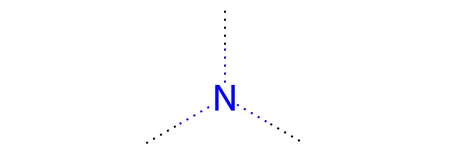

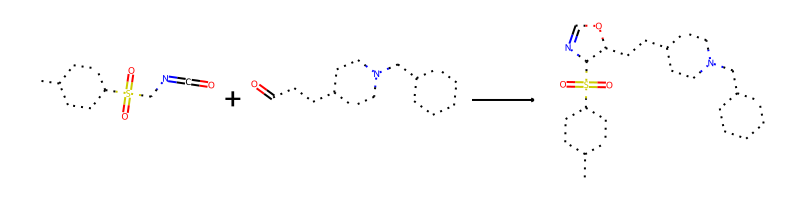

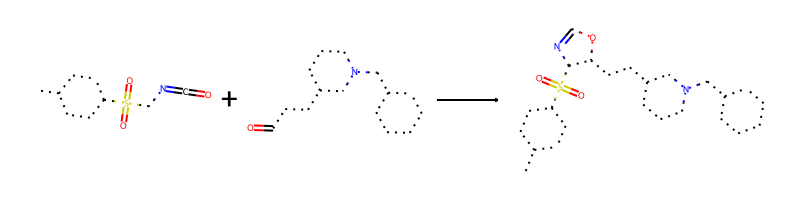

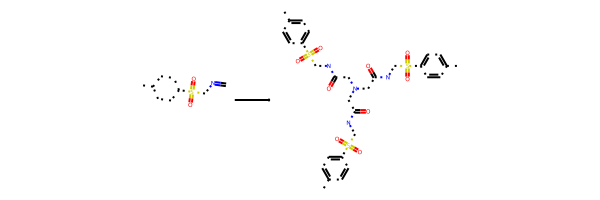

In [171]:
look_for_subtructures(rxns, '[CH2][N]([CH2])([CH2])')

## Lookning for complexity generation; the bigger l2 norm of the rxn fp  the greater diffrence between starting materials and products

In [97]:
norms = [np.linalg.norm(list(r.fp)) for r in rxns]

Text(0, 0.5, 'Rxns count')

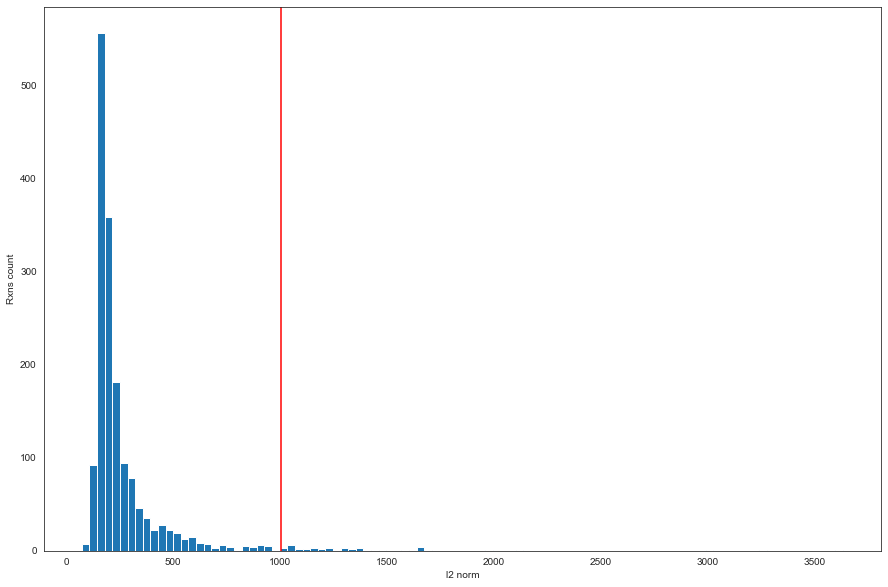

In [106]:
plt.figure(figsize=(15,10))
plt.hist(norms, bins=100)
plt.axvline(norms[-1], c='r')
plt.xlabel('l2 norm')
plt.ylabel('Rxns count')

# Interestingly only few rxns have higher l2 norm lets print them 

In [113]:
idxs = np.where(norms>norms[-1])[0]
print('Number of rxns {}'.format(len(idxs)))

Number of rxns 40


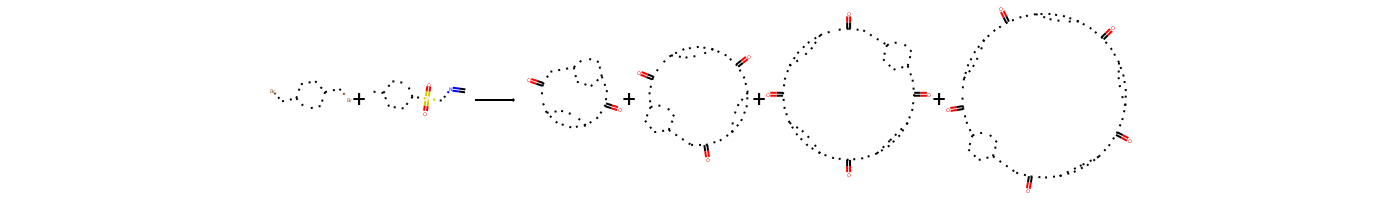

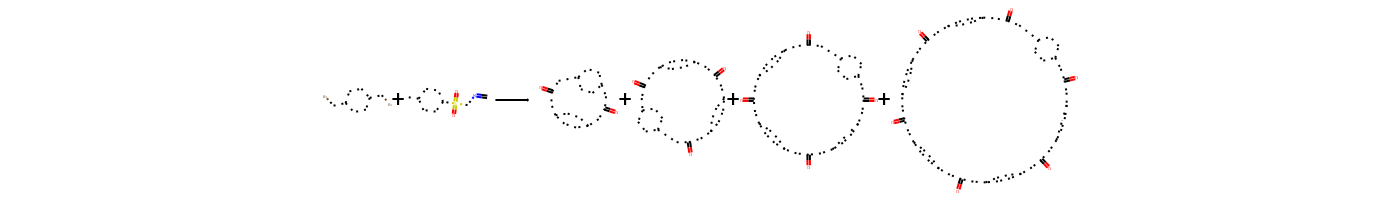

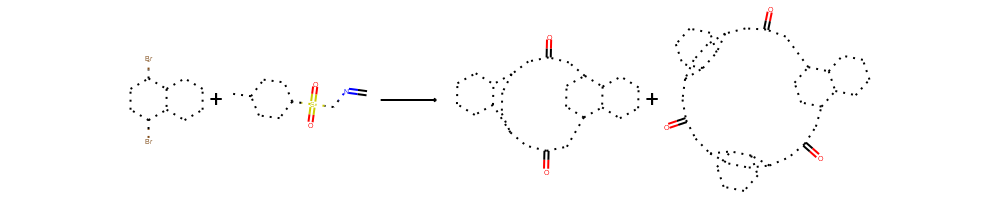

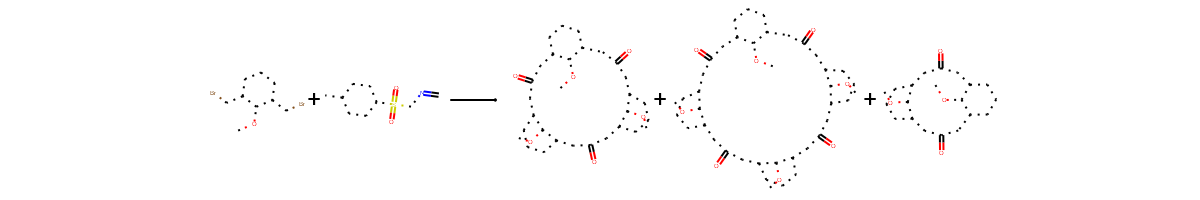

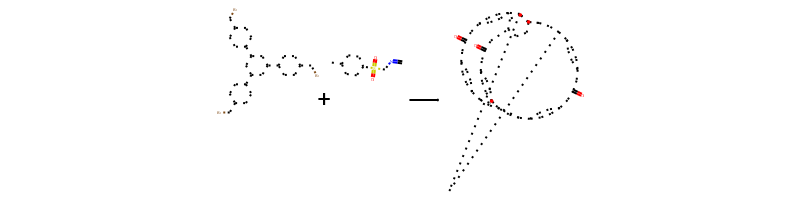

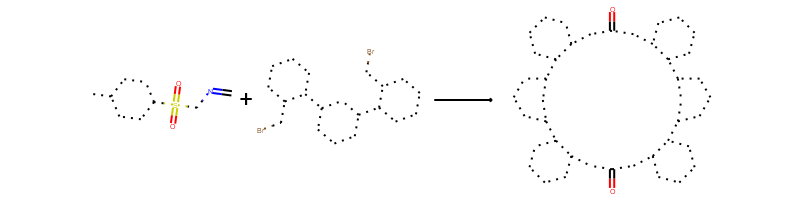

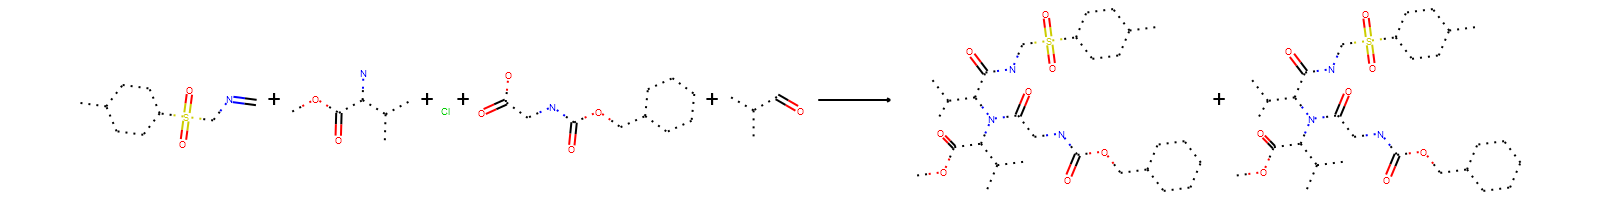

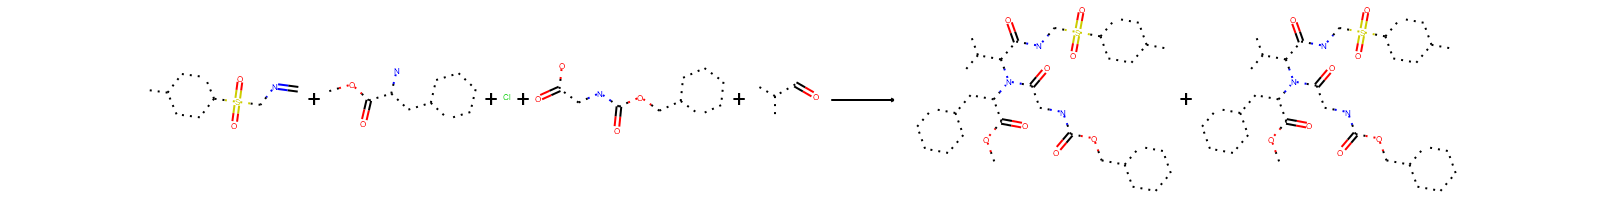

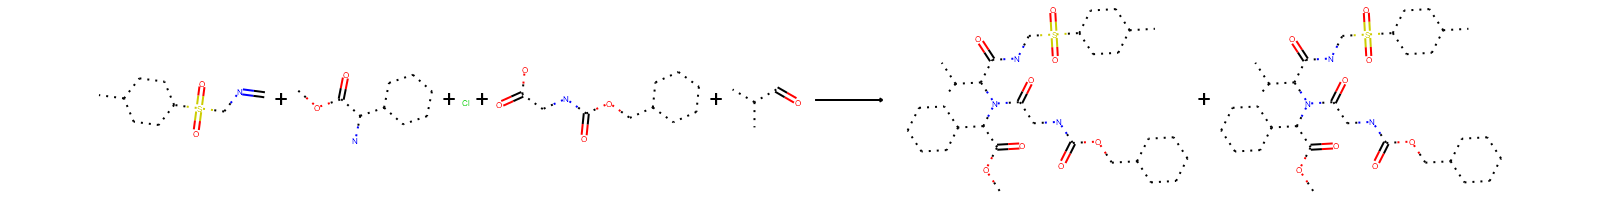

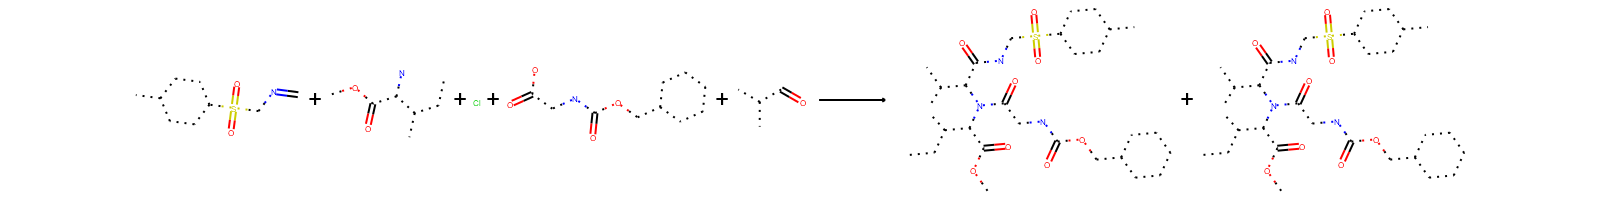

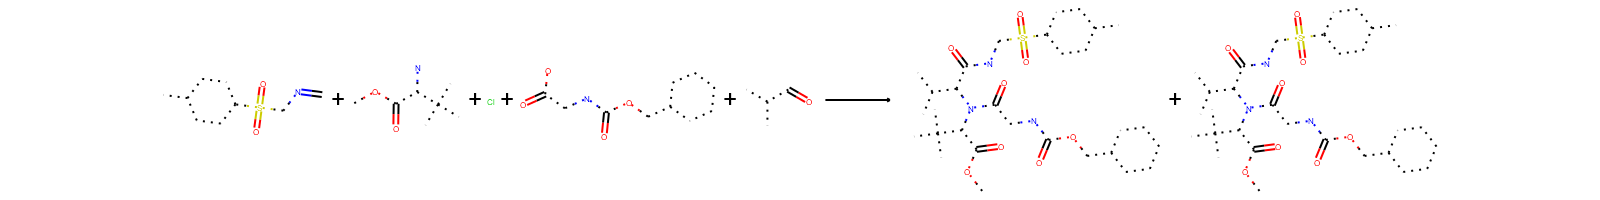

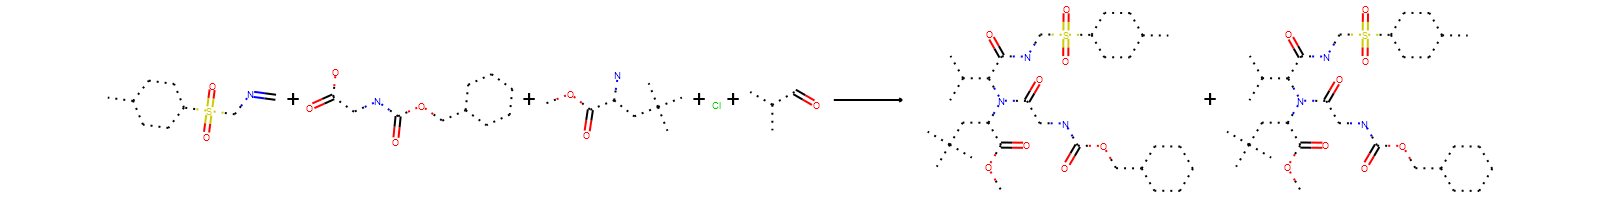

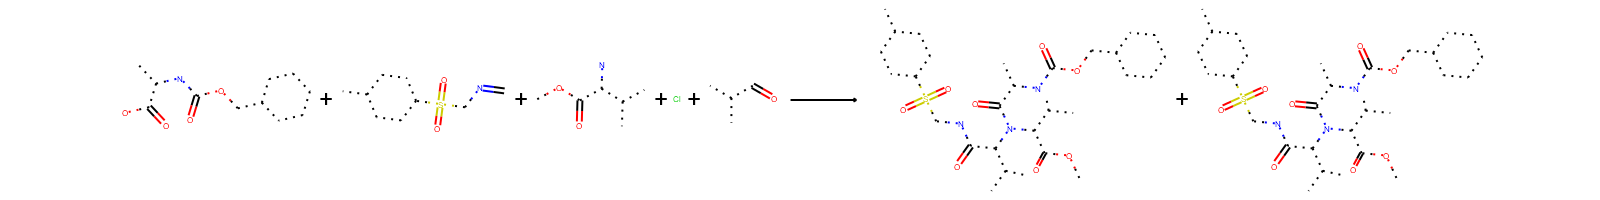

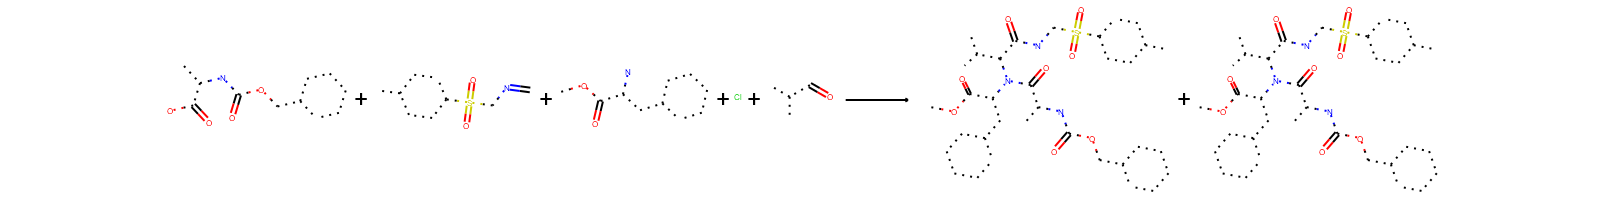

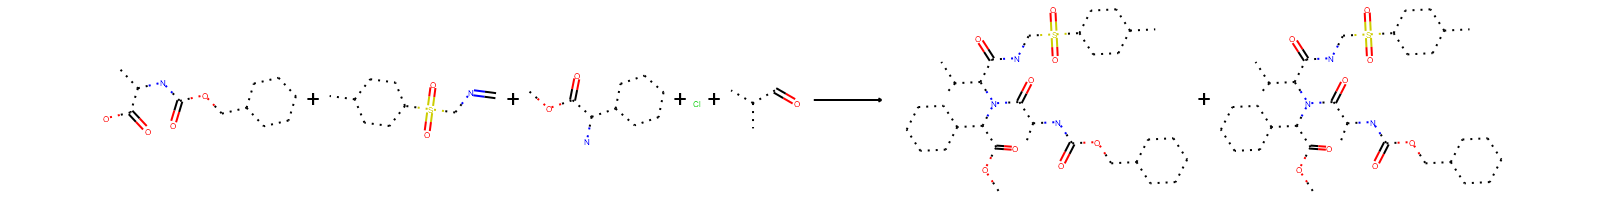

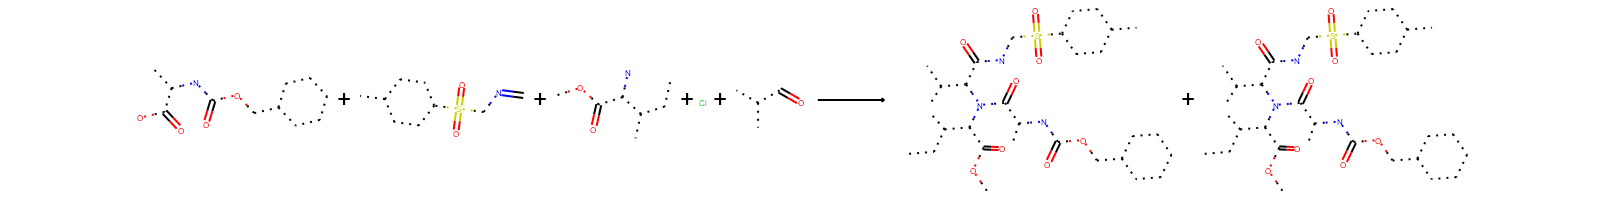

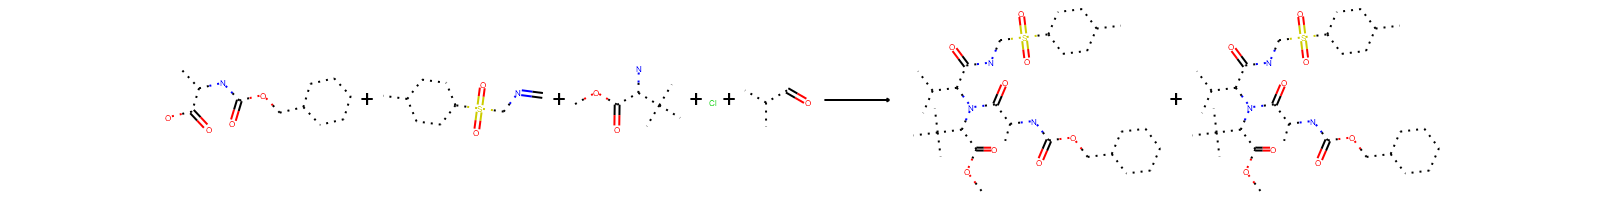

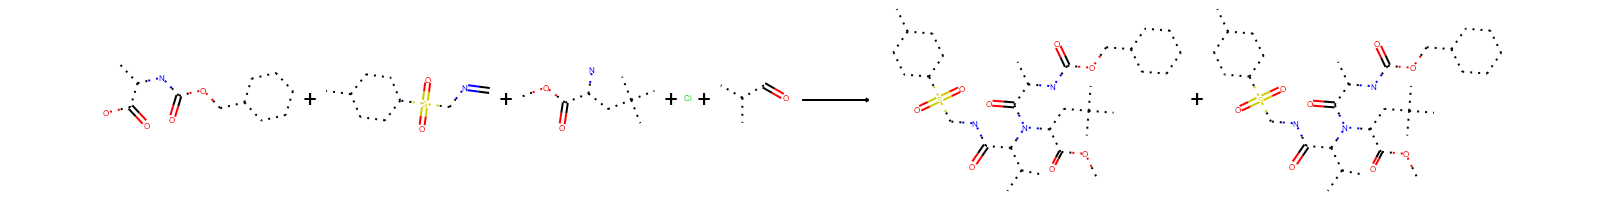

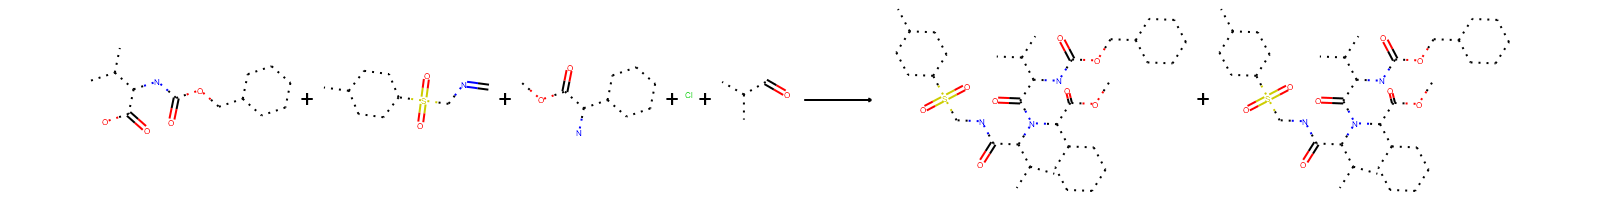

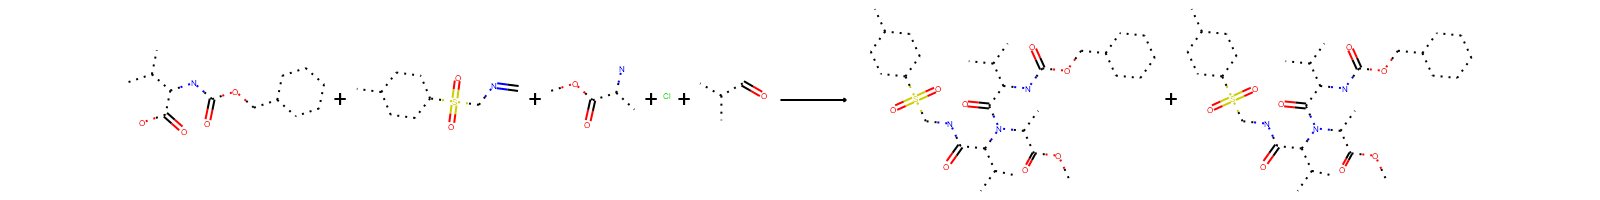

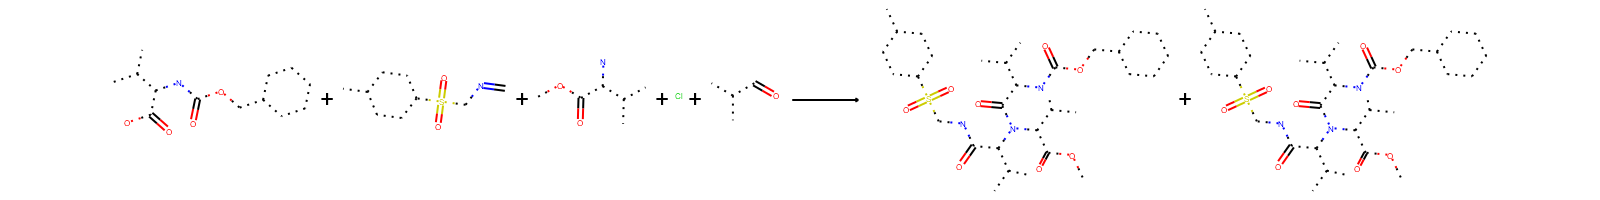

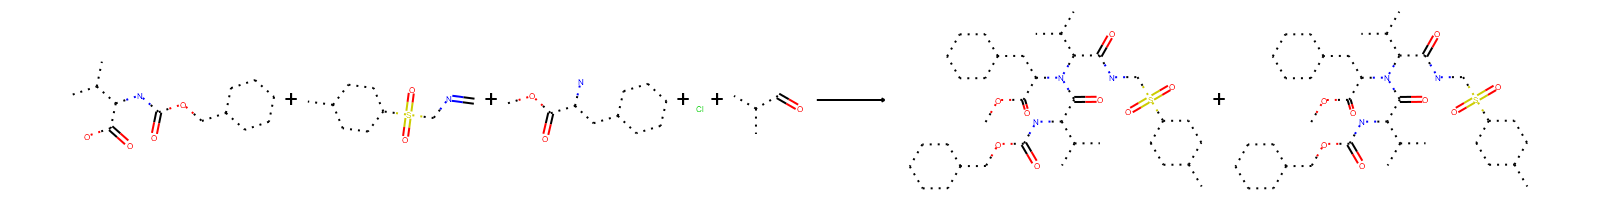

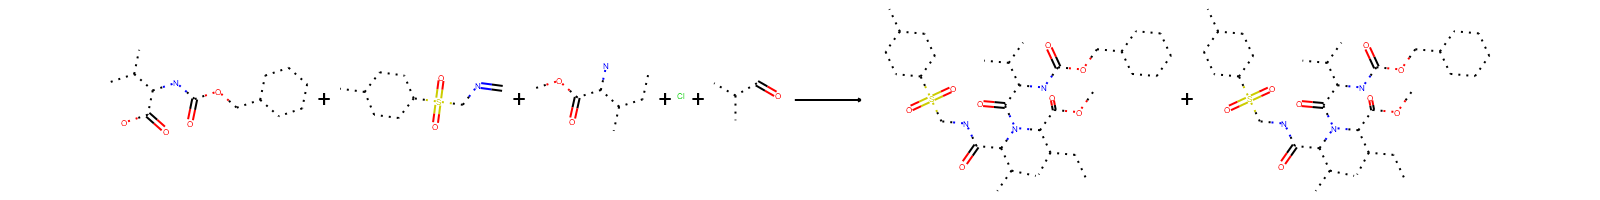

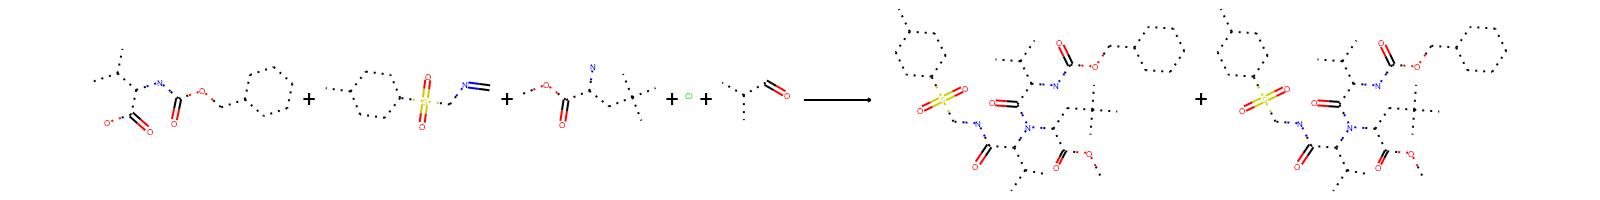

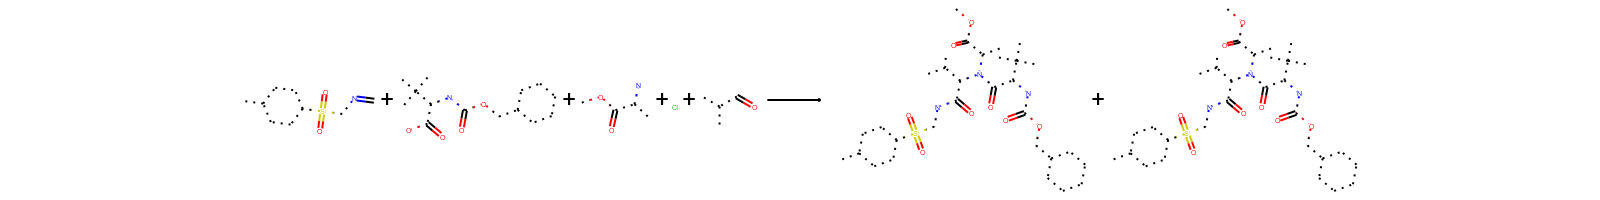

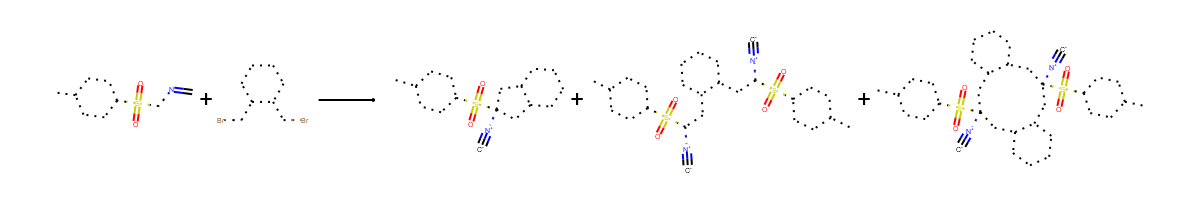

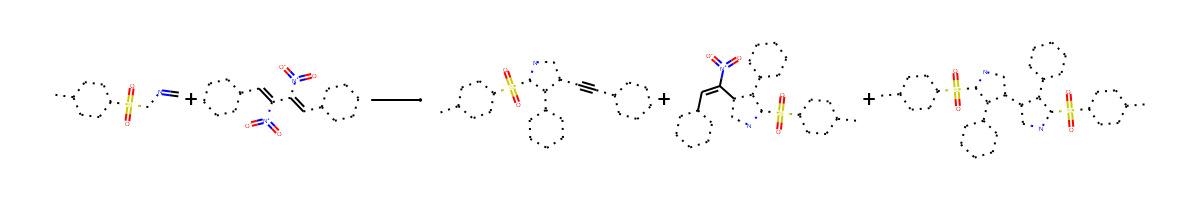

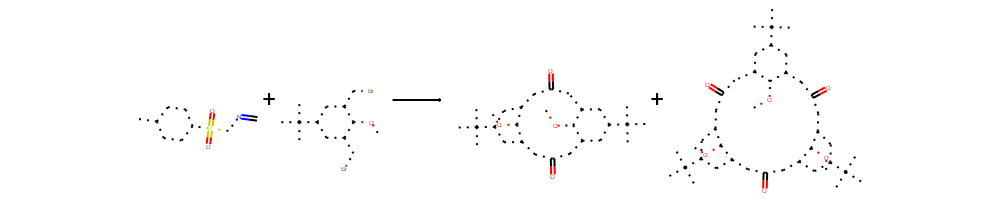

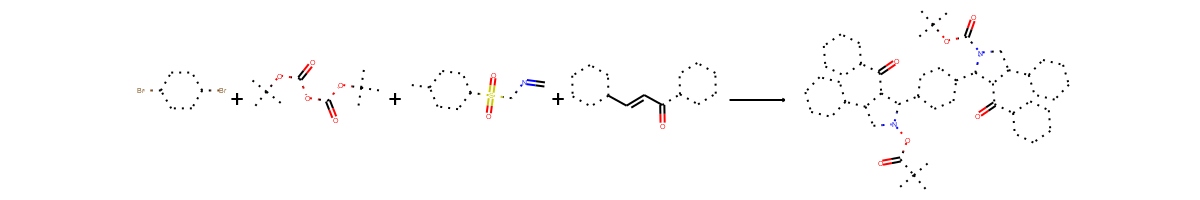

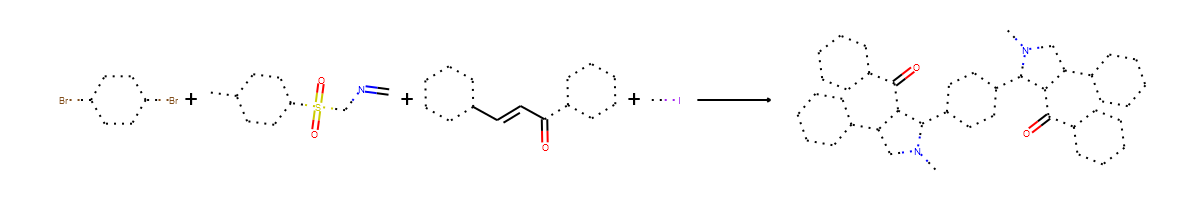

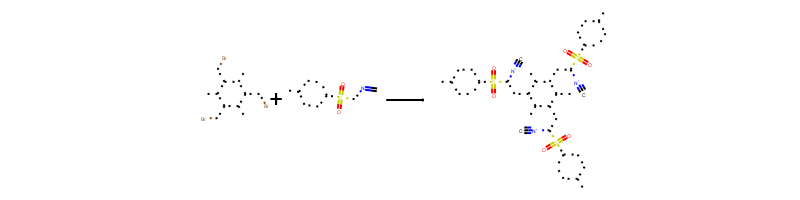

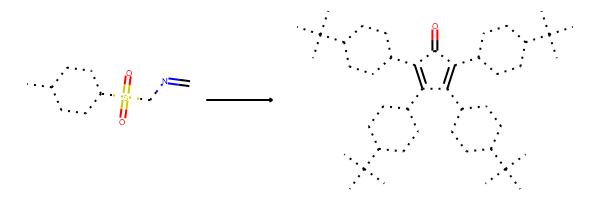

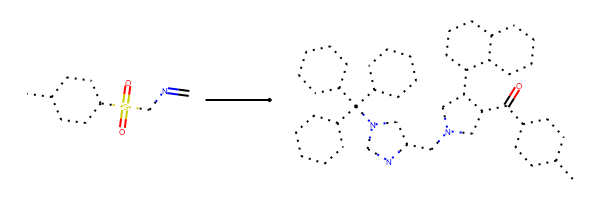

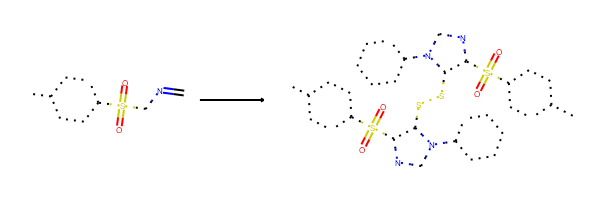

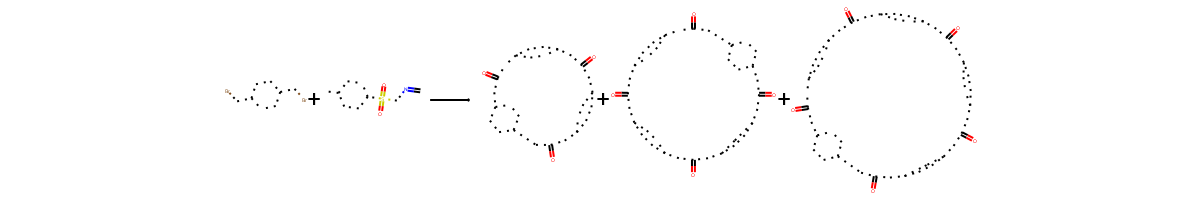

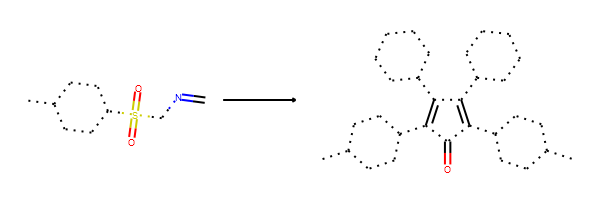

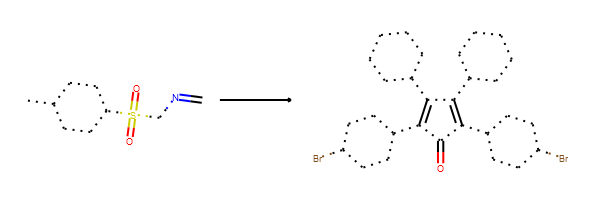

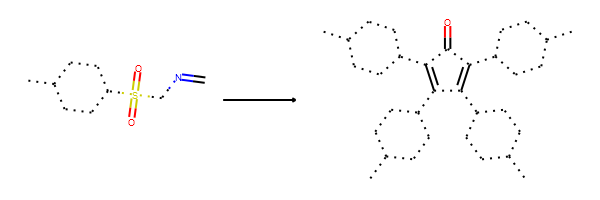

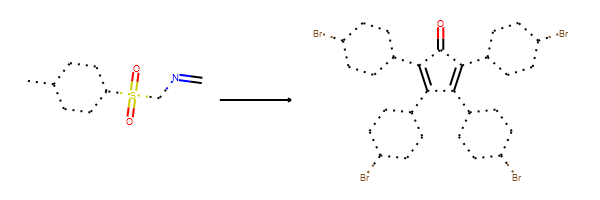

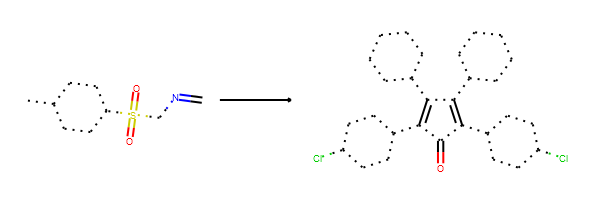

In [114]:
for rxn_id in idxs:
    rxn = rdChemReactions.ReactionFromSmarts(rxns[rxn_id].rxn_smiles)
    img = Draw.ReactionToImage(rxn)
    display(img)

In [110]:
idxs

(array([  79,   80,  150,  160,  163,  254,  391,  392,  393,  394,  395,
         396,  405,  406,  407,  408,  409,  410,  411,  413,  414,  415,
         416,  417,  418,  431,  491,  497,  695,  698, 1001, 1246, 1248,
        1304, 1414, 1464, 1465, 1466, 1467, 1469], dtype=int64),)